# Behold the Mighty Pileup

In [4]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-white')
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
import bbi

In [2]:
mm9 = bioframe.fetch_chromsizes('mm9')
chromsizes = bioframe.fetch_chromsizes('mm9')
chromosomes = list(chromsizes.index)

In [13]:
conditions = ['WT', 'dN']
binsize = 10000

cooler_paths = {    
    'WT' : f'data/UNTR.{binsize}.cool',
    'T'  : f'data/TAM.{binsize}.cool',
    'dN' : f'data/NIPBL.{binsize}.cool',
}
long_names = {
    'WT': 'Wildtype',
    'T' : 'TAM',
    'dN': 'NipblKO',
}
pal = sns.color_palette('colorblind')
colors = {
    'WT': pal[0],
    'T' : '#333333',
    'dN': pal[2],
}

clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

## Single landmark pileup

In [14]:
from cooltools import snipping

In [15]:
ctcf = pd.read_table('data/CtcfCtrl.mm9__VS__InputCtrl.mm9.narrowPeak_with_motif.txt.gz')
ctcf.head()

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit,chrom_m,start_m,end_m,name_m,score_m,strand_m,pval_m
0,chr14,73909345,73910139,Peak_1,2864,.,66.97627,286.44055,277.00751,386,chr14,73909703,73909716,CTCF_mouse,12.8061,-,1.610000e-05
1,chr8,73292691,73293764,Peak_10,2288,.,59.05101,228.89639,222.17598,738,chr8,73293454,73293467,CTCF_mouse,14.2242,+,6.080000e-06
2,chr10,99078331,99079198,Peak_100,1567,.,40.02444,156.79012,151.30066,303,chr10,99078650,99078663,CTCF_mouse,19.7758,+,6.020000e-08
3,chr19,44437901,44438397,Peak_1000,741,.,20.84388,74.12866,69.69677,273,chr19,44438190,44438203,CTCF_mouse,15.1212,-,3.280000e-06
4,chr1,145853760,145854152,Peak_10000,355,.,12.38549,35.59266,32.22501,189,chr1,145853924,145853937,CTCF_mouse,17.6242,+,3.710000e-07


In [16]:
sites = ctcf.sort_values('fc', ascending=False).iloc[:1000]
sites.head()

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit,chrom_m,start_m,end_m,name_m,score_m,strand_m,pval_m
39612,chr2,28440591,28441124,Peak_7,2444,.,67.20400,244.48576,237.52400,289,chr2,28440889,28440902,CTCF_mouse,17.1879,+,5.530000e-07
0,chr14,73909345,73910139,Peak_1,2864,.,66.97627,286.44055,277.00751,386,chr14,73909703,73909716,CTCF_mouse,12.8061,-,1.610000e-05
8403,chr12,85930537,85931240,Peak_18,2221,.,66.84265,222.16884,215.60326,320,chr12,85930837,85930850,CTCF_mouse,17.9212,+,2.800000e-07
5278,chr11,78267090,78267719,Peak_15,2240,.,66.48611,224.05933,217.43312,301,chr11,78267350,78267363,CTCF_mouse,17.9636,-,2.770000e-07
40800,chr11,98203663,98204470,Peak_8,2370,.,65.88831,237.03339,230.20671,426,chr11,98204100,98204113,CTCF_mouse,20.5697,-,2.070000e-08


In [17]:
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

flank = 600000
windows = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom'], 
    (sites['start_m'] + sites['end_m'])//2,
    flank_bp=flank)
windows['strand'] = sites['strand_m']
windows = snipping.assign_regions(windows, supports)
windows = windows.dropna()

print(len(windows), 'windows, after assigning supports')
windows.head()

1000 windows, after assigning supports


,chrom,start,end,lo,hi,strand,region
39612,chr2,27840000,29050000,2784,2905,+,chr2:0-181748087
0,chr14,73300000,74510000,7330,7451,-,chr14:0-125194864
8403,chr12,85330000,86540000,8533,8654,+,chr12:0-121257530
5278,chr11,77660000,78870000,7766,7887,-,chr11:0-121843856
40800,chr11,97600000,98810000,9760,9881,-,chr11:0-121843856


In [18]:
stacks = {}
piles = {}
for cond in conditions:
    expected = pd.read_table(f'data/{long_names[cond]}.{binsize//1000}kb.expected.cis.tsv')
    snipper = snipping.ObsExpSnipper(clrs[cond], expected)
    
    stack = snipping.pileup(windows, snipper.select, snipper.snip)
    
    # mirror reflect snippets whose feature is on the opposite strand
    mask = np.array(windows.strand == '+', dtype=bool)
    stack[:, :, mask] = stack[::-1, ::-1, mask]
    
    stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)

/home/nezar/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


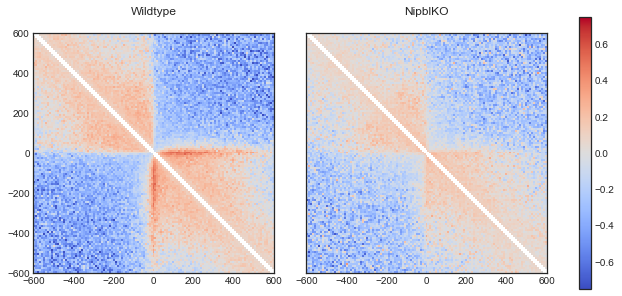

In [19]:
gs = GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
plt.figure(figsize=(5 * len(conditions), 5))

opts = dict(
    vmin=-0.75,
    vmax=0.75,
    extent=[-flank//1000, flank//1000, -flank//1000, flank//1000],
    cmap='coolwarm'
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        np.log2(piles[cond]),  
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

## Inspect examples

In [27]:
from ipywidgets import interact

gs = GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
n_examples = len(windows)

@interact(i=(0, n_examples-1))
def f(i):
    plt.figure(figsize=(5 * len(conditions), 5))
    for j, cond in enumerate(conditions):
        ax = plt.subplot(gs[j])
        img = ax.matshow(
            np.log2(stacks[cond][:, :, i]),  
            **opts)
        ax.xaxis.tick_bottom()
        if i > 0:
            ax.yaxis.set_visible(False)
        plt.title(long_names[cond])
        plt.axvline(0, c='g', ls='--')
        plt.axhline(0, c='g', ls='--')

interactive(children=(IntSlider(value=499, description='i', max=999), Output()), _dom_classes=('widget-interact',))

## Piling up paired landmarks

In [36]:
anchor_dist = 300000
anchor_flank = 10000
sites = pd.read_table('data/ctcf-sites.paired.300kb_flank10kb.tsv.1')

# "convergent" orientation of paired CTCF motifs
sites = sites[(sites['strand1'] == '+') & (sites['strand2'] == '-')]

print(len(sites))
sites.head()

In [40]:
snippet_flank = 250000

windows1 = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom1'], 
    sites['mid1'],
    flank_bp=snippet_flank)
windows1['strand'] = sites['strand1']

windows2 = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom2'], 
    sites['mid2'],
    flank_bp=snippet_flank)
windows2['strand'] = sites['strand2']

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = snipping.assign_regions(windows, supports)
windows = windows.dropna()
windows.head()

,chrom1,start1,end1,lo1,hi1,strand1,chrom2,start2,end2,lo2,hi2,strand2,region
0,chr11,97950000,98460000,9795,9846,+,chr11,98360000,98870000,9836,9887,-,chr11:0-121843856
1,chr2,27800000,28310000,2780,2831,+,chr2,28190000,28700000,2819,2870,-,chr2:0-181748087
2,chr8,72650000,73160000,7265,7316,+,chr8,73040000,73550000,7304,7355,-,chr8:0-131738871
3,chr7,74120000,74630000,7412,7463,+,chr7,74520000,75030000,7452,7503,-,chr7:0-152524553
4,chr9,77190000,77700000,7719,7770,+,chr9,77600000,78110000,7760,7811,-,chr9:0-124076172


In [41]:
stacks = {}
piles = {}
for cond in conditions:
    expected = pd.read_table(f'data/{long_names[cond]}.{binsize//1000}kb.expected.cis.tsv')
    snipper = snipping.ObsExpSnipper(clrs[cond], expected)
    stack = snipping.pileup(windows, snipper.select, snipper.snip)
    stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)

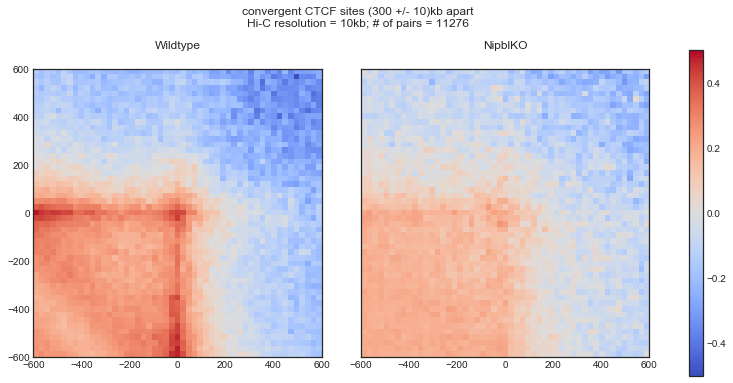

In [42]:
gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
plt.figure(figsize=(6 * len(conditions), 6))

opts = dict(
    vmin=-0.5,
    vmax=0.5,
    extent=[-flank//1000, flank//1000, -flank//1000, flank//1000],
    cmap='coolwarm'
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        np.log2(np.nanmean(stacks[cond], axis=2)), #piles[cond]),  
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

plt.suptitle(f'convergent CTCF sites ({anchor_dist//1000} +/- {anchor_flank//1000})kb apart\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {len(windows)}')